In [1]:

# data manipulation
from g2p_client import G2PDatabase
import pandas as pd

# plotting
from IPython.display import set_matplotlib_formats
from __future__ import division
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#  The resulting plots will then also be stored in the notebook document, with big fonts
%matplotlib inline
sns.set(font_scale=2)

# our ES instance
INDEX = 'associations'
HOST = 'elastic'
DATABASE = G2PDatabase(HOST, INDEX)


In [2]:
# get a dataframe with features, environment, features and evidence
# ( for the details, pass verbose flag to print query)
associations_df = DATABASE.associations_dataframe(verbose=True)

{
  "query": {
    "query_string": {
      "query": "-source:*trials +features.start:* +association.phenotype.type:* +association.environmentalContexts.id:* "
    }
  },
  "_source": {
    "includes": [
      "source",
      "association.evidence_label",
      "genes",
      "association.phenotype.type.id",
      "association.phenotype.type.term",
      "association.environmentalContexts.id",
      "association.environmentalContexts.term",
      "association.evidence.info.publications",
      "features"
    ]
  }
}
{
  "feature_centric": 21155,
  "evidence_centric": 21155,
  "original": 9056,
  "environment_centric": 17320
}


In [3]:
# as we can see its panda friendly
print associations_df.shape
associations_df.head(4)

(21155, 21)


,environmentalContext.id,environmentalContext.term,evidence.id,evidence_label,feature.alt,feature.biomarker_type,feature.chromosome,feature.description,feature.end,feature.entrez_id,...,feature.genomic_hgvs,feature.name,feature.ref,feature.referenceName,feature.start,gene_list,phenotype.id,phenotype.term,publication_count,source
0,compound:CID3062316,DASATINIB,n2E8MmABo7W0JU3G36DY,A,None,polymorphism,22,NaN,23632600.0,25.0,...,no_hgvs:BCR-ABL,BCR-ABL,None,GRCh37,23522397.0,ABL1,DOID:8552,chronic myeloid leukemia,1,civic
1,compound:CID3062316,DASATINIB,n2E8MmABo7W0JU3G36DY,A,None,polymorphism,22,NaN,23632600.0,25.0,...,no_hgvs:BCR-ABL,BCR-ABL,None,GRCh37,23522397.0,ABL1,DOID:8552,chronic myeloid leukemia,1,civic
2,compound:CID644241,NILOTINIB,n2E8MmABo7W0JU3G36DY,A,None,polymorphism,22,NaN,23632600.0,25.0,...,no_hgvs:BCR-ABL,BCR-ABL,None,GRCh37,23522397.0,ABL1,DOID:8552,chronic myeloid leukemia,1,civic
3,compound:CID644241,NILOTINIB,n2E8MmABo7W0JU3G36DY,A,None,polymorphism,22,NaN,23632600.0,25.0,...,no_hgvs:BCR-ABL,BCR-ABL,None,GRCh37,23522397.0,ABL1,DOID:8552,chronic myeloid leukemia,1,civic


In [4]:
counts = pd.pivot_table(associations_df, 
               index=['source', 'evidence_label'], 
               values=['evidence.id'],
               aggfunc='count',
               fill_value=0,
               margins = True)
uniques = pd.pivot_table(associations_df, 
               index=['source', 'evidence_label'], 
               values=['evidence.id'],
               aggfunc=lambda _id: len(_id.unique()),
               fill_value=0,
               margins = True)
pd.concat([counts, uniques], axis=1, join_axes=[counts.index])

evidence.id  evidence.id
source         evidence_label                          
cgi            A                       224          212
               B                        13            8
               C                       202          153
               D                       195          159
civic          A                        80           33
               B                      1424          593
               C                      1352          651
               D                      2063          903
jax            A                       146           71
               B                       184           81
               C                      2142          863
               D                      9879         3564
molecularmatch A                      1283          711
               B                       175           86
               C                       275          138
               D                      1195          719
oncokb         A                       124           26
               B                        38           13
               C                        53           23
               D                       108           49
All                                  21155         9056

In [5]:
counts = pd.pivot_table(associations_df, 
               index=['source', 'evidence_label'], 
               values=['feature.genomic_hgvs'],
               aggfunc='count',
               fill_value=0,
               margins = True)
uniques = pd.pivot_table(associations_df, 
               index=['source', 'evidence_label'], 
               values=['feature.genomic_hgvs'],
               aggfunc=lambda _id: len(_id.unique()),
               fill_value=0,
               margins = True)
pd.concat([counts, uniques], axis=1, join_axes=[counts.index])

feature.genomic_hgvs  feature.genomic_hgvs
source         evidence_label                                            
cgi            A                                224                   120
               B                                 13                     4
               C                                202                   111
               D                                195                   114
civic          A                                 80                    15
               B                               1424                   120
               C                               1352                   203
               D                               2063                   236
jax            A                                146                    25
               B                                184                    21
               C                               2142                   222
               D                               9879                   498
molecularmatch A                               1283                   295
               B                                175                    71
               C                                275                    97
               D                               1195                   295
oncokb         A                                124                    22
               B                                 38                     7
               C                                 53                    21
               D                                108                    34
All                                           21155                  1451

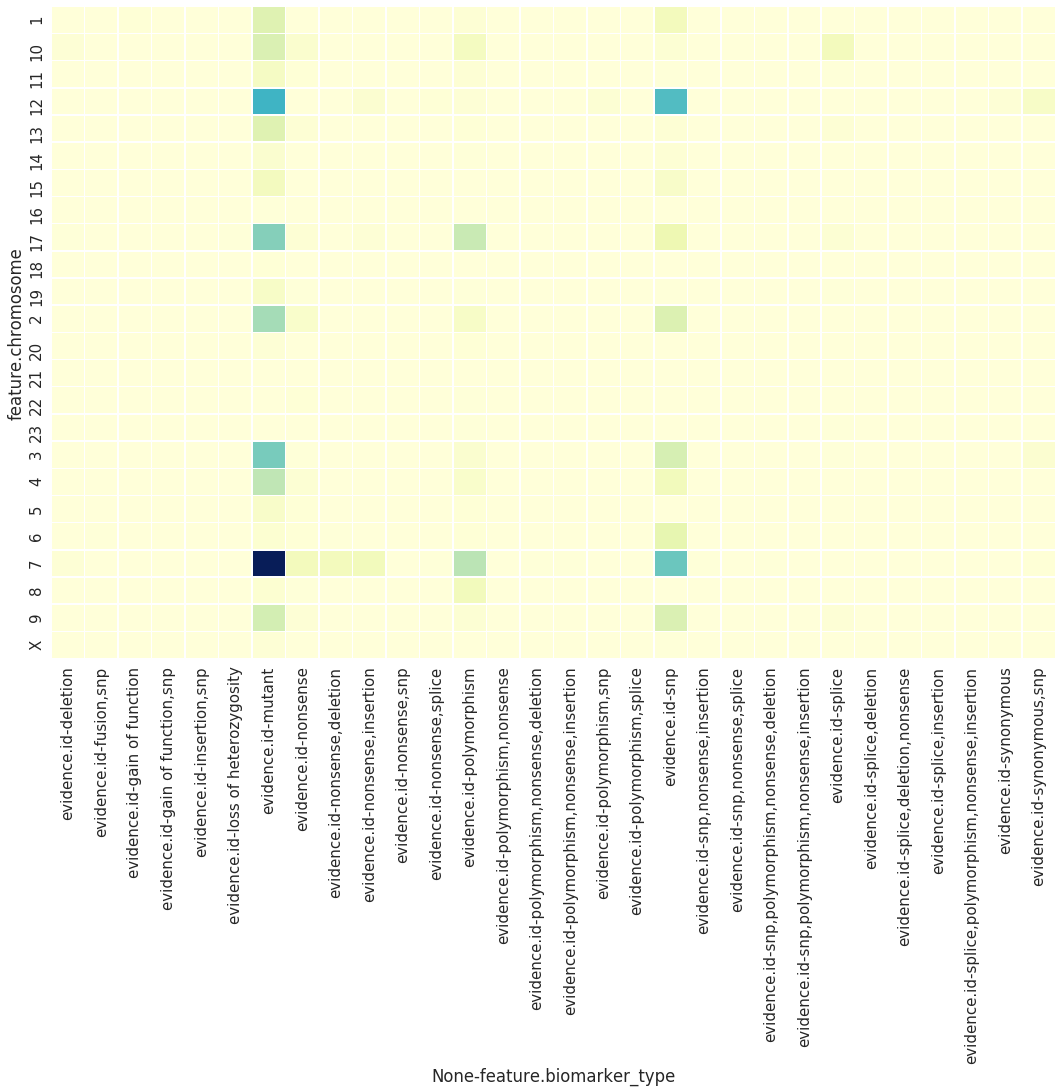

In [7]:
# create a pivot table to sum publication count 
table = pd.pivot_table(associations_df, 
                       index=['feature.chromosome'],
                       columns=['feature.biomarker_type'], 
                       values=['evidence.id'],
                       aggfunc=lambda _id: len(_id.unique()),                       
                       fill_value=0)

# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.set(font_scale=1.5)

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(table, fmt="1.0f", linewidths=.5, ax=ax, cbar=False, cmap="YlGnBu") 



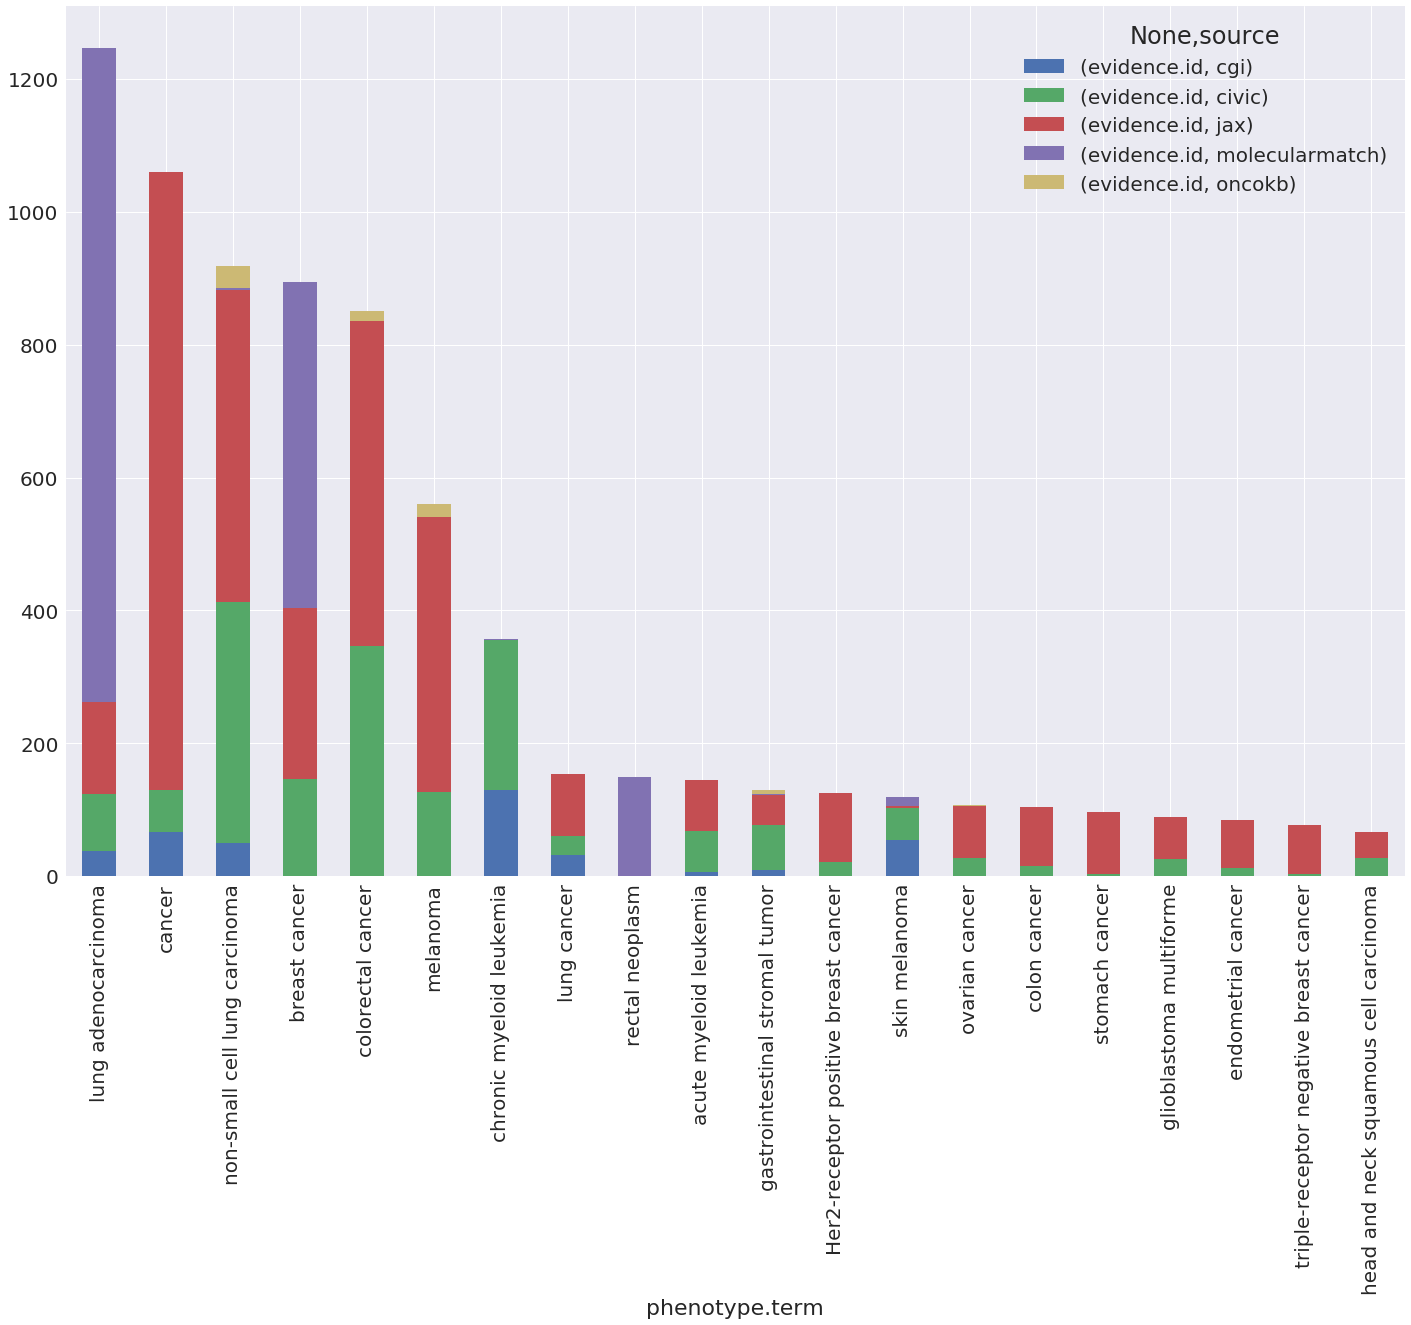

In [9]:
sns.set(font_scale=2)

table = pd.pivot_table(associations_df,
                       index=["phenotype.term","source"],
                       values=['evidence.id'],
                       aggfunc=lambda _id: len(_id.unique()),                                              
                       fill_value=0)

cmp = plt.cm.get_cmap('jet')
s_sort = table.groupby(level=[0]).sum().sort_values(by=['evidence.id'],ascending=False)
table = table.reindex(index=s_sort.index, level=0).unstack(fill_value=0)


table.head(20).plot(kind='bar',  stacked=True,  figsize=(24, 16))


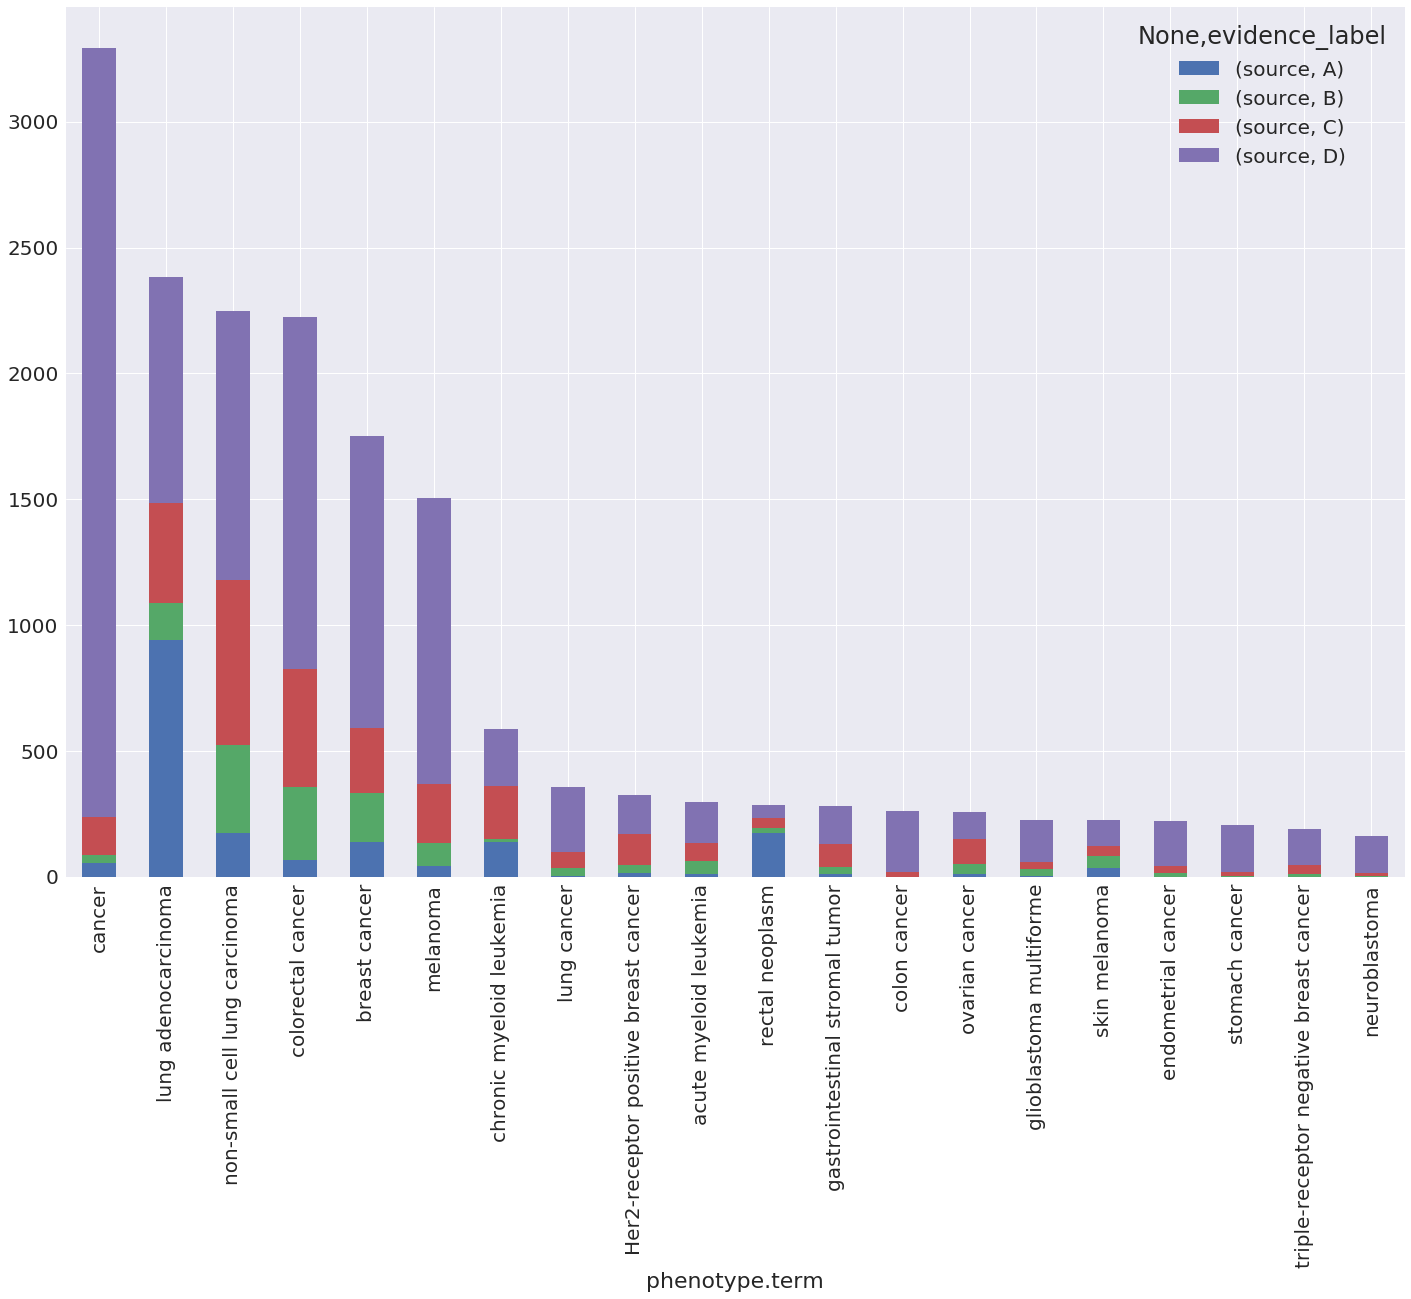

In [18]:
sns.set(font_scale=2)

table = pd.pivot_table(associations_df,
                       index=["phenotype.term","evidence_label"],
                       values=['source'],
                       aggfunc='count')
cmp = plt.cm.get_cmap('jet')
s_sort = table.groupby(level=[0]).sum().sort_values(by=['source'],ascending=False)
table = table.reindex(index=s_sort.index, level=0).unstack(fill_value=0)


table.head(20).plot(kind='bar',  stacked=True,  figsize=(24, 16))


# G2P Phenotype / Chromosome distribution
* map g2p phenotype to chromosome

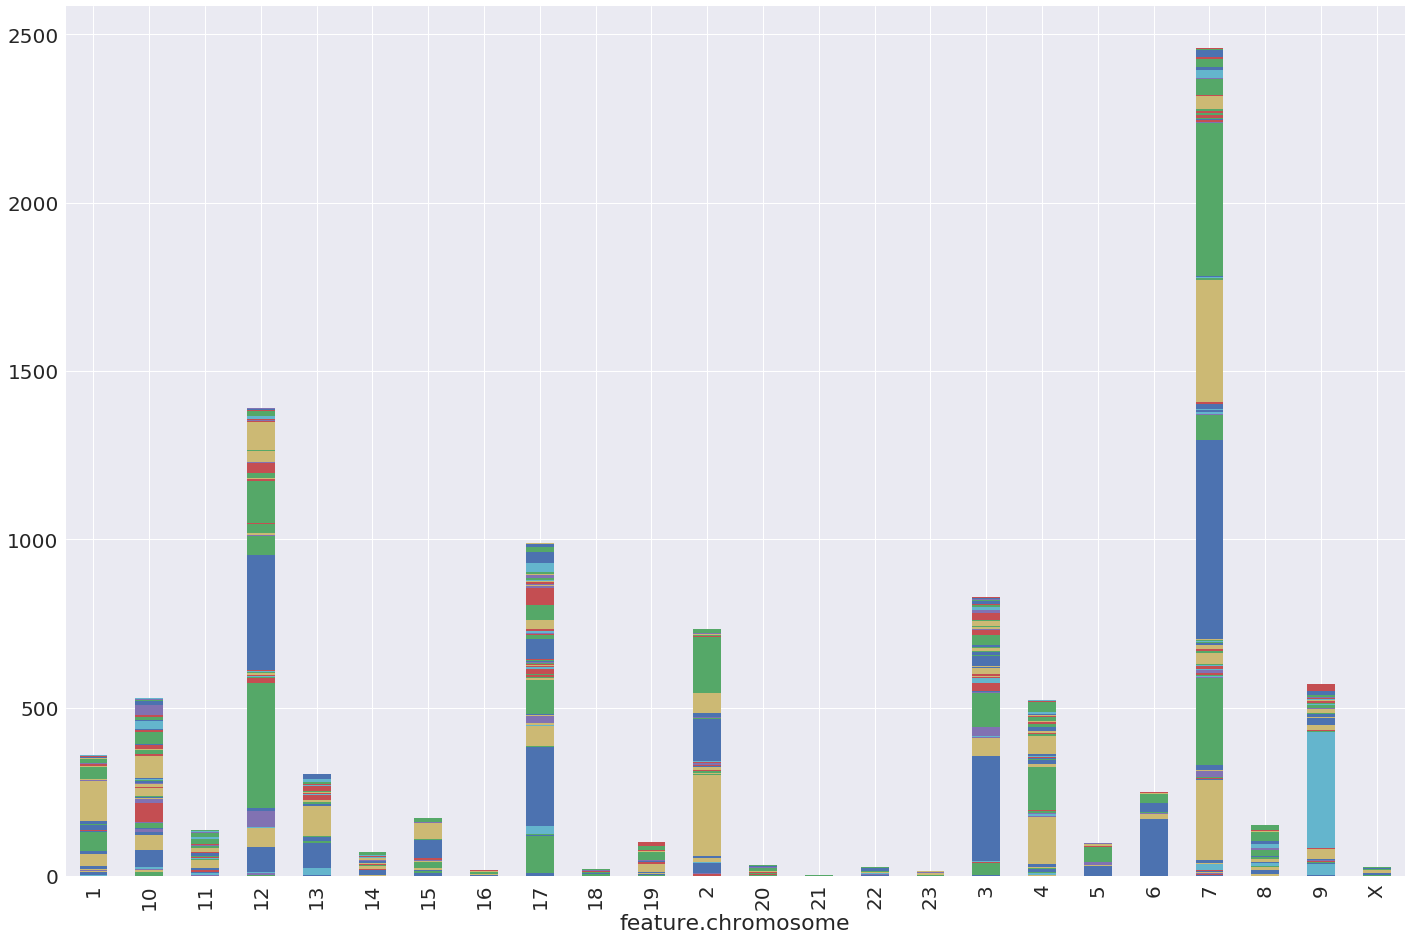

In [15]:
# create a pivot table to sum publication count by phenotype and chromosome
table = pd.pivot_table(associations_df, 
                       index=['feature.chromosome'],
                       columns=['phenotype.term'], 
                       values=['evidence.id'],
                       aggfunc=lambda _id: len(_id.unique()),                                              
                       fill_value=0)


table.plot(kind='bar',  stacked=True,  figsize=(24, 16), legend=None )


# Load GENIE database

In [65]:
# Load GENIE variants.
GENIE_VARIANTS = '/util/data_mutations_extended_1.0.1.txt'
genie_df = pd.read_csv(GENIE_VARIANTS, sep='\t', comment='#')


In [68]:
# set the indices on the df to the same feature attribute
genie_df.set_index(['Chromosome',
               'Start_Position',
               'End_Position',
               'Reference_Allele',
               'Tumor_Seq_Allele2'])

associations_df.set_index(['feature.chromosome',
                           'feature.start',
                           'feature.end',
                           'feature.ref',
                           'feature.alt' ])
# join the dataframes
genie_associations_df = pd.concat([genie_df, associations_df], axis=1)
genie_associations_df.groupby(['feature.chromosome', 'feature.start' , 'feature.end' , 
                    'feature.ref'    , 'feature.alt' ])


# GENIE Tumor Samples / Phenotype / Chromosome distribution
* map genie Tumor_Sample_Barcode to chromosome

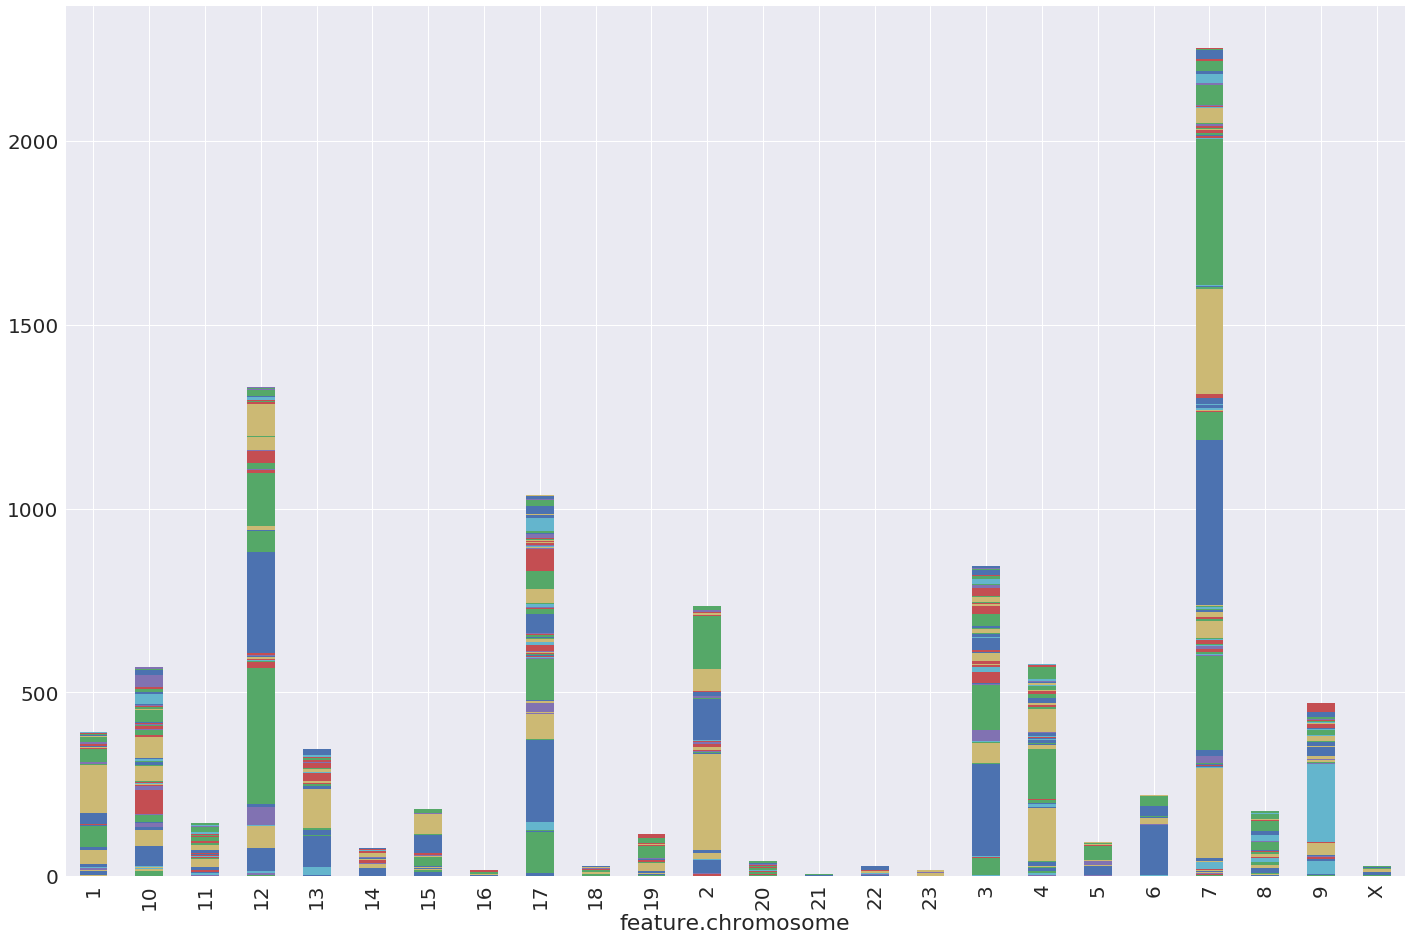

In [73]:
# create a pivot table to sum publication count by phenotype and chromosome
table = pd.pivot_table(genie_associations_df, 
                       index=['feature.chromosome'],
                       columns=['phenotype.term'], 
                       values=['Tumor_Sample_Barcode'],
                       aggfunc=lambda _id: len(_id.unique()),                                              
                       fill_value=0)

table.plot(kind='bar',  stacked=True,  figsize=(24, 16), legend=None )


# GENIE Tumor Samples / Evidence Label / Chromosome distribution
* map genie Tumor_Sample_Barcode to chromosome

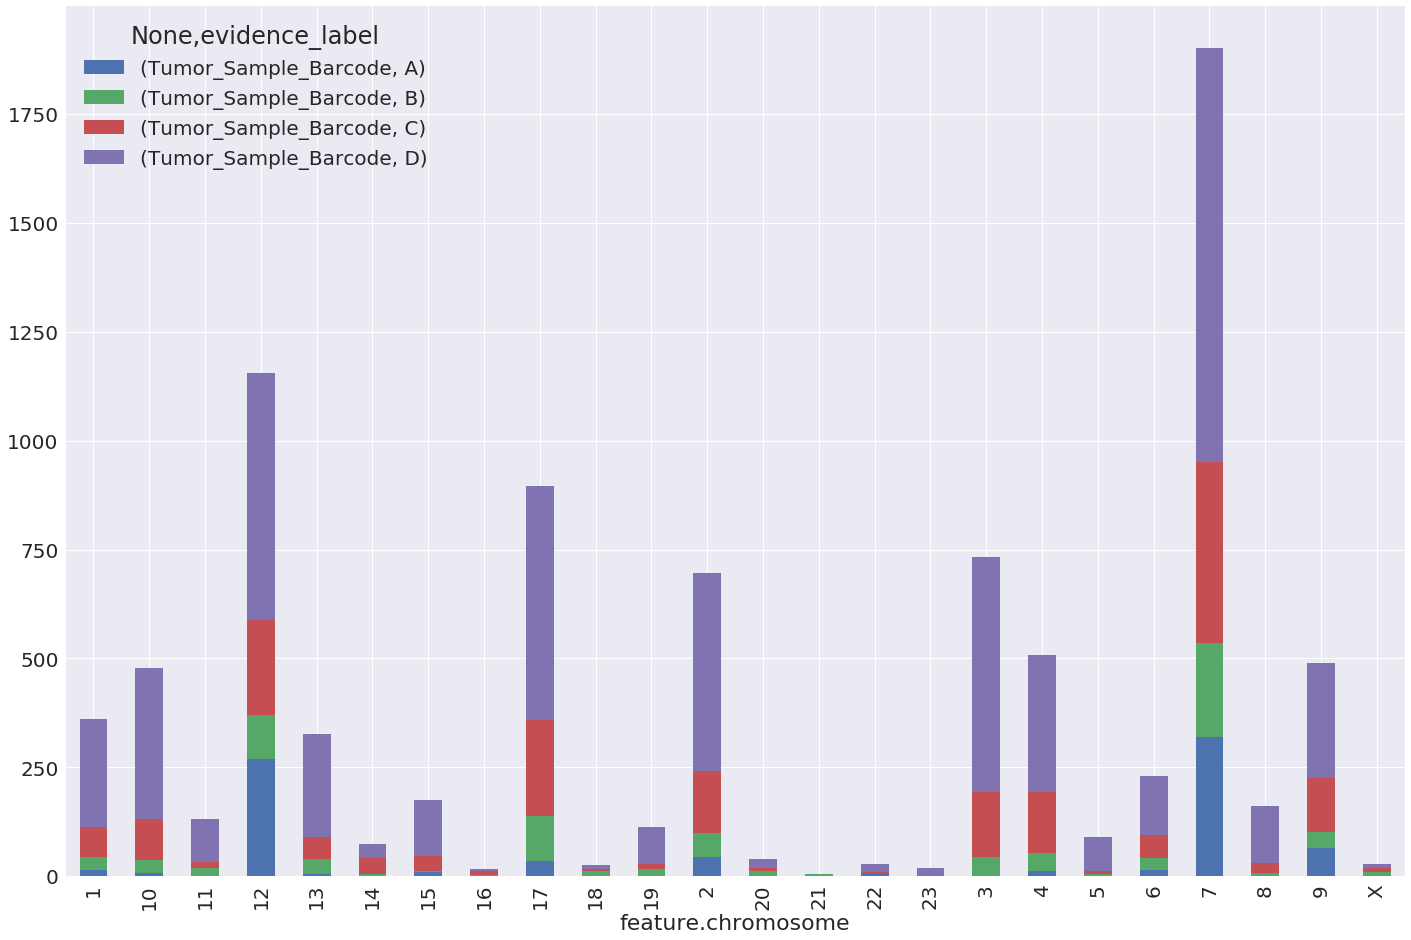

In [84]:

# create a pivot table to sum publication count by phenotype and chromosome
table = pd.pivot_table(genie_associations_df, 
                       index=['feature.chromosome'],
                       columns=['evidence_label'], 
                       values=['Tumor_Sample_Barcode'],
                       aggfunc=lambda _id: len(_id.unique()),                                              
                       fill_value=0)
table.plot(kind='bar',  stacked=True,  figsize=(24, 16) )
